In [1]:
%load_ext autoreload
%autoreload 2
import pyfits
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
import glob
import os
from matplotlib.path import Path
from scipy import optimize as op
from scipy.ndimage.interpolation import rotate, shift
%matplotlib inline
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18

# Calculate 1D projection of luminosity L(r)
## rotate the image so that galaxy is aligned on x axis

#### Chto Clever Idea

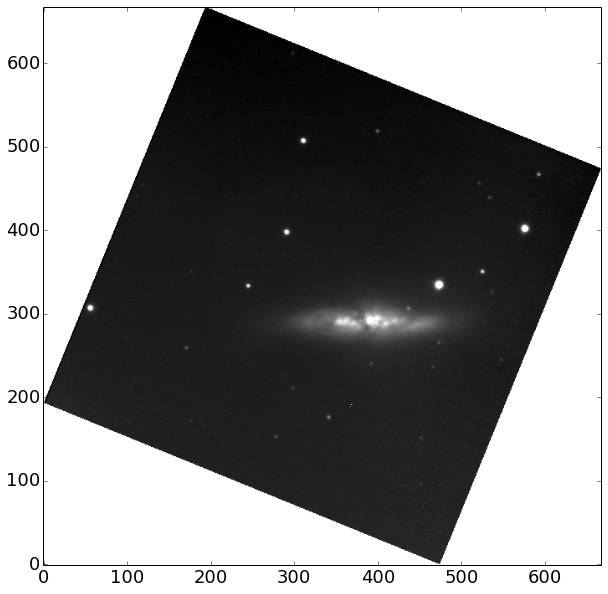

In [2]:
data = pyfits.open('/afs/.ir/users/i/a/iameric/physics100/workdir/g2/final/image/R/coadd/coadd.fits')[0].data
dataRotated = rotate(data,22.2, order=5)
plt.figure(figsize=(10,10))
plt.imshow(dataRotated, origin="lowerleft",norm=LogNorm(), cmap="gray")
plt.clim(800,2500)

## select the region of interest

In [3]:
#dataRotated = rotate(data,0, order=5)
cutData=dataRotated[250:350, 250:550]

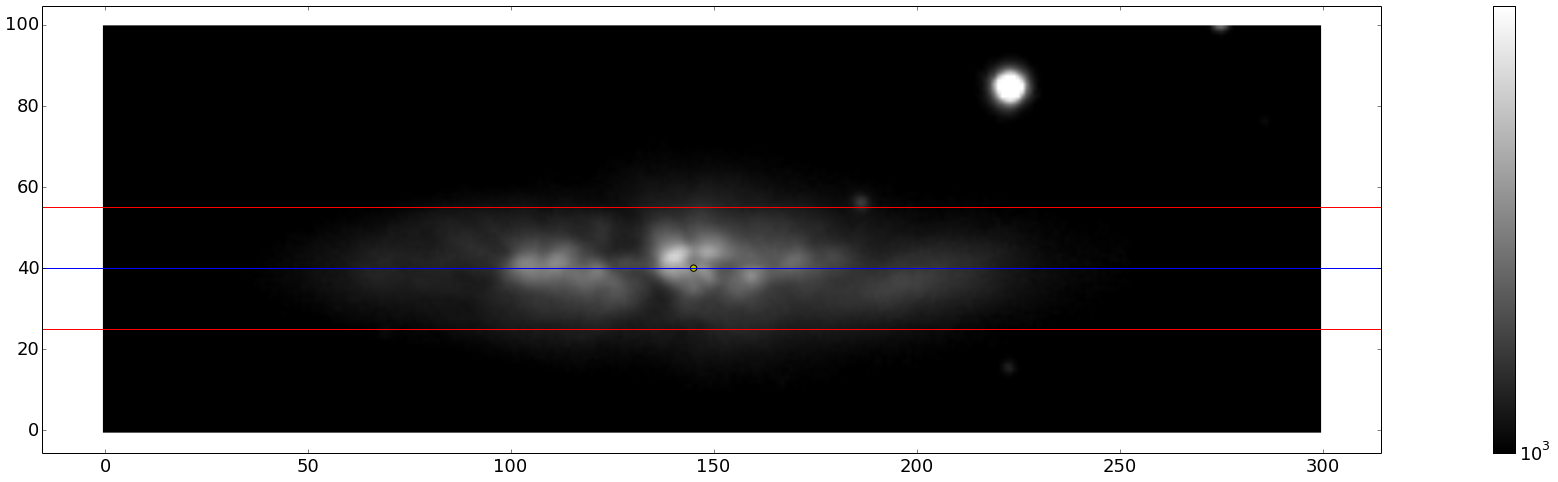

In [7]:
fig=plt.figure(figsize=(40,8))
plt.imshow(cutData,origin="lowerleft",norm=LogNorm(), cmap="gray",vmin=1000,vmax=5000)
plt.colorbar()
cx,cy = (145,40)
dodox,dodoy = (145,40)
plt.scatter(dodox,dodoy,s=40,c='y')
cent=40
dist=15
plt.axhline(cent,c="b")
plt.axhline(cent-dist, c="r")
plt.axhline(cent+dist, c="r")

In [8]:
upper=cent+dist
lower=cent-dist
radius=(np.arange(21)-10)*4
croppedData=cutData[lower:upper,:]
cx,cy = np.array([140,40])-np.array([0,lower])


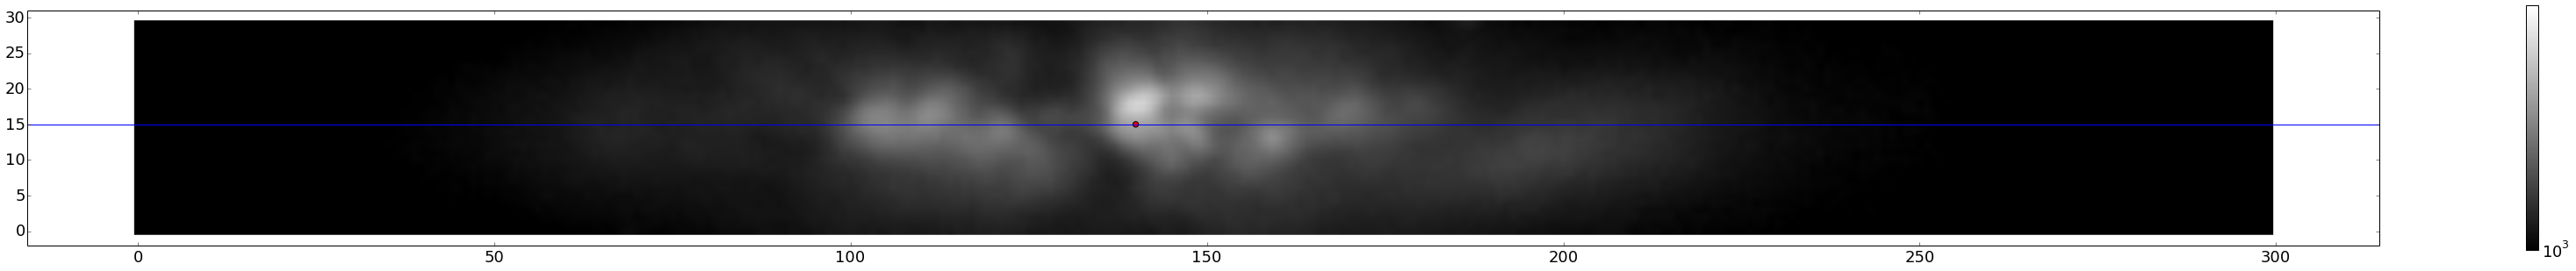

In [9]:
fig=plt.figure(figsize=(60,5))
plt.imshow(croppedData,origin="lowerleft",norm=LogNorm(), cmap="gray",vmin=1000,vmax=5000)

plt.colorbar()
plt.scatter(cx,cy,s=40,c='r')
cent=cy
dist=20
plt.axhline(cent,c="b")
#plt.axhline(cent-dist, c="r")
#plt.axhline(cent+dist, c="r")

## plot the 1D projection of the flux

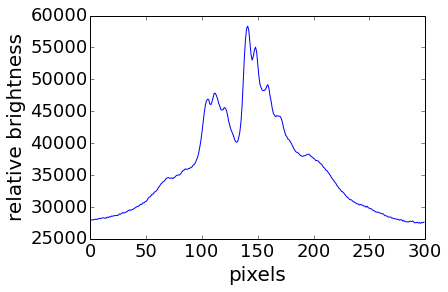

In [10]:
projected_R=np.sum(croppedData,axis=0)
plt.plot(projected_R)
plt.xlabel("pixels")
plt.ylabel("relative brightness")

## Do the same for G and B band

In [11]:
data = pyfits.open('/afs/.ir/users/i/a/iameric/physics100/workdir/g2/final/image/G/coadd/coadd.fits')[0].data
dataRotated = rotate(data,22.2, order=5)
cutData=dataRotated[250:350, 250:550]
cent=40
dist=15
upper=cent+dist
lower=cent-dist
radius=(np.arange(21)-10)*4
croppedData=cutData[lower:upper,:]
cx,cy = np.array([140,40])-np.array([0,lower])

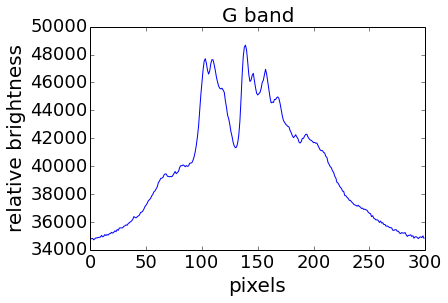

In [12]:
projected_G=np.sum(croppedData,axis=0)
plt.plot(projected_G)
plt.xlabel("pixels")
plt.ylabel("relative brightness")
plt.title("G band")

In [13]:
data = pyfits.open('/afs/.ir/users/i/a/iameric/physics100/workdir/g2/final/image/B/coadd/coadd.fits')[0].data
dataRotated = rotate(data,22.2, order=5)
cutData=dataRotated[250:350, 250:550]
cent=40
dist=15
upper=cent+dist
lower=cent-dist
radius=(np.arange(21)-10)*4
croppedData=cutData[lower:upper,:]
cx,cy = np.array([140,40])-np.array([0,lower])

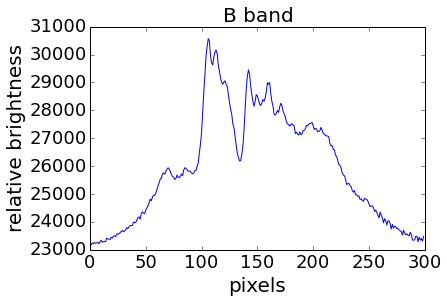

In [14]:
projected_B=np.sum(croppedData,axis=0)
plt.plot(projected_B)
plt.xlabel("pixels")
plt.ylabel("relative brightness")
plt.title("B band")

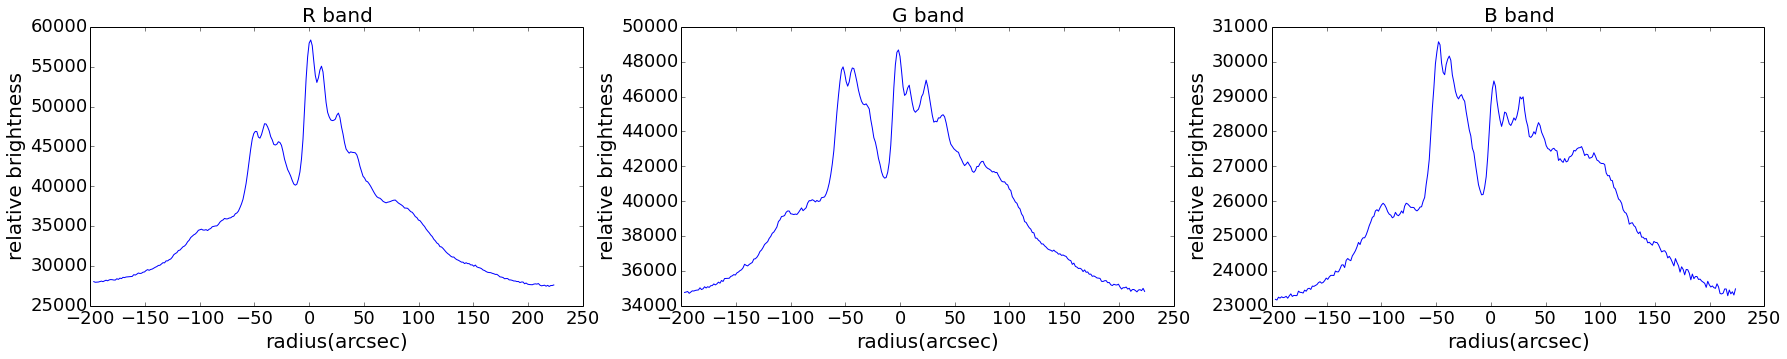

In [15]:
fig=plt.figure(figsize=(30,5))
p2arsec = 12*60/512.
r = (np.arange(0,300)-cx)*p2arsec
plt.subplot(131)
plt.plot(r,projected_R)
plt.xlabel("radius(arcsec)")
plt.ylabel("relative brightness")
plt.title("R band")
plt.subplot(132)
plt.plot(r,projected_G)
plt.xlabel("radius(arcsec)")
plt.ylabel("relative brightness")
plt.title("G band")
plt.subplot(133)
plt.plot(r,projected_B)
plt.xlabel("radius(arcsec)")
plt.ylabel("relative brightness")
plt.title("B band")

In [16]:
100/p2arsec

71.11111111111111

## Plot the ration of R and G band

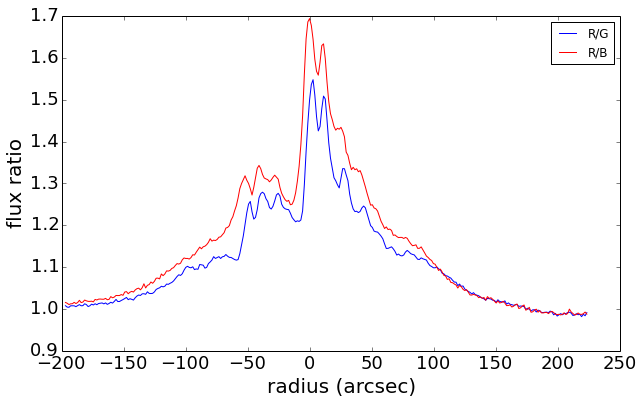

In [17]:
p2arsec = 12*60/512.
r = (np.arange(0,300)-cx)*p2arsec
plt.figure(figsize=(10,6))
plt.plot(r,projected_R/projected_G*1.25,label="R/G")
plt.plot(r,projected_R/projected_B*0.84,'r',label="R/B")
#plt.plot(r,projected_G/projected_B/1.5,'g',label="G/B")
plt.legend()
plt.xlabel('radius (arcsec)')
plt.ylabel("flux ratio")
#plt.axhline(1.1)
#plt.xlim([-30,30])

## Fit for L(r)
Our ansatz is $L(r)=\frac{\exp(-r/h_r)}{\sqrt{r^2-R^2}}$

There's probably a way to calculate and correct for the extinction, but for now let's just use R band larger than 60 pixel to fit for L(r)

In [18]:
rpixel = (np.arange(0,300)-cx)
mask=np.where(np.abs(rpixel)>70)
rmasked=rpixel[mask]
projected_R_masked=projected_R[mask]

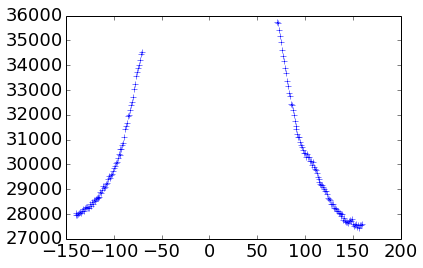

In [19]:
plt.plot(rmasked, projected_R_masked, "+")

## fit the right side

In [20]:
rightRadius=rmasked[np.where(rmasked>0)]
rightLum = projected_R_masked[np.where(rmasked>0)]
rightNorm = rightLum - min(rightLum)

In [21]:
def fitFunction(Rarray, hr,A,C):
    rmax=1000
    y=[]
    for R in Rarray:
        r=np.arange(R+0.2,rmax,0.01)
        y.append(A*np.trapz(np.exp(-r/hr)*r/np.sqrt(r**2-R**2), r)+C)
    y=np.array(y)
    return y

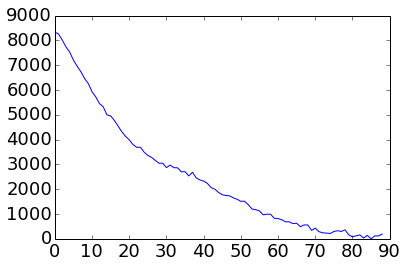

In [22]:
plt.plot(rightNorm)

In [23]:
 popt, pcov = op.curve_fit(fitFunction, rightRadius,rightNorm, p0=(25,1500,50))

Ro: 39.0257253191, A: 1967.83323101, C:-449.086502864


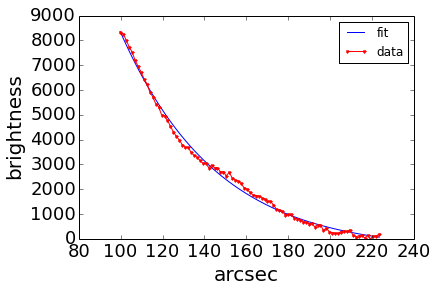

In [26]:
plt.plot(rightRadius*p2arsec, fitFunction(rightRadius, *popt), label="fit")
plt.plot(rightRadius*p2arsec,rightNorm,marker='.',c="r",label='data')
plt.legend()
print "Ro: {0}, A: {1}, C:{2}".format(popt[0]*p2arsec, popt[1], popt[2])
plt.xlabel("arcsec")
plt.ylabel("brightness")

In [27]:
x = np.arange(-300, 300.3, 0.3)
y = np.arange(-300, 300.3, 0.3)
xv, yv = np.meshgrid(x, y)

<matplotlib.colorbar.Colorbar instance at 0x7f57740e98c0>

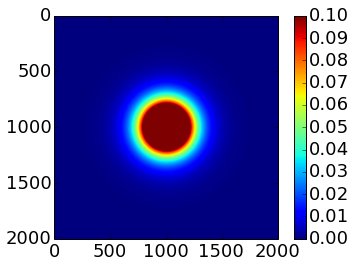

In [28]:
M=np.exp(-np.sqrt((xv**2+yv**2))/popt[0])
plt.imshow(M, vmax=0.1,vmin=0.0)
plt.colorbar()

# Assume M$\propto$R, calculate the gravitation potential and rotation curve
divide the disk up to many small parts, to avoid numerical problems, we exclude points that are too close to the specified x.

In [29]:
def U(x):
    cent=np.array([x,0])
    distArray=np.sqrt(((xv-x)**2+yv**2))
    mask=np.where(distArray>1.)
    Utotal=-np.nansum(M[mask]/distArray[mask])
    return Utotal

In [30]:
#np.save('/afs/.ir/users/i/a/iameric/physics100/workdir/g2/final/saves/Utotal.npy',Utotal)

In [31]:
#Utotal=np.load('/afs/.ir/users/i/a/iameric/physics100/workdir/g2/final/saves/Utotal.npy')

In [32]:
x=np.arange(1,100,1)
Utotal=[]
for item in x:
    Utotal.append(U(item))

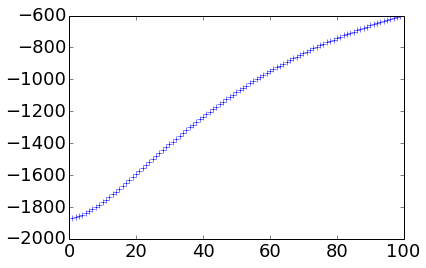

In [33]:
plt.plot(x,Utotal,"+")

Use spline to fit this potential

In [108]:
from scipy.interpolate import UnivariateSpline

In [109]:
spl = UnivariateSpline(x, Utotal, k=4, s=10)

In [110]:
spl.derivative()

In [111]:
def rotation_curve_exp(r):
    p2arsec = 12*60/512.
    rp = r/p2arsec
    derivative=spl.derivative()(rp)
    velocity=np.sqrt(rp*derivative)
    return velocity

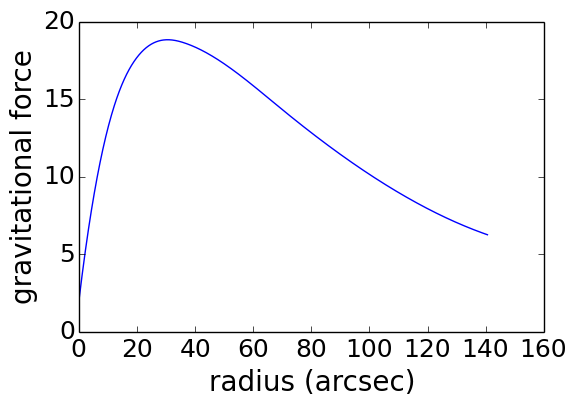

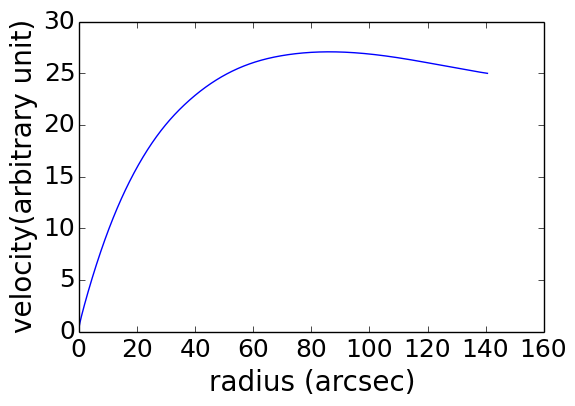

In [112]:
p2arsec = 12*60/512.
radius = np.linspace(0,100,1000)
derivative =spl.derivative()(radius)
velocity=np.sqrt(radius*derivative)
fig=plt.figure()
plt.plot(radius*p2arsec, derivative)
plt.xlabel("radius (arcsec)")
plt.ylabel("gravitational force")

fig=plt.figure()
plt.plot(radius*p2arsec, velocity)
plt.xlabel("radius (arcsec)")
plt.ylabel("velocity(arbitrary unit)")

## Keplerian curve

In [113]:
7.5e3/3.6e6/np.pi*180*3600

429.7183463481174

In [114]:
def rotation_curve_kep(r,R_0):
    # set the size of the bulge to be 20 arcsec
    #R_0=20.
    v0 = 1./np.sqrt(R_0)
    v = np.ones_like(r).astype('float')
    v[np.where(r<=R_0)] = v0*r[np.where(r<=R_0)]/R_0
    v[np.where(r>R_0)] = 1/np.sqrt(r[np.where(r>R_0)])
    return v

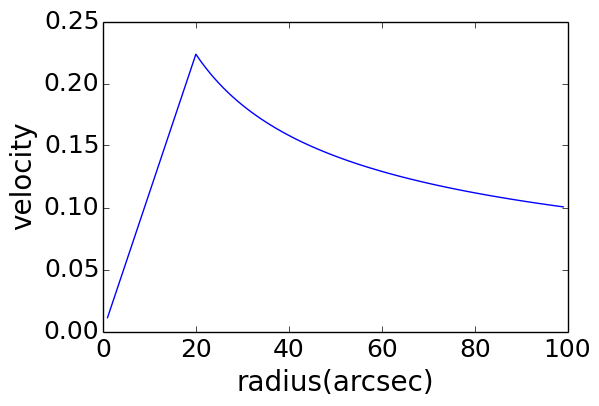

In [115]:
plt.plot(x,rotation_curve_kep(x,20))
plt.xlabel("radius(arcsec)")
plt.ylabel('velocity')

# Fit our actual rotation curve with the combination of the two curves
load rotation curve

In [34]:
M82_spa_binned = np.load('/afs/.ir/users/i/a/iameric/physics100/workdir/g2/Jason/Project/others/rot_cv_spa.npy')
M82_spa_binerr = np.load('/afs/.ir/users/i/a/iameric/physics100/workdir/g2/Jason/Project/others/rot_cv_spaerr.npy')
M82_vel_binned = np.load('/afs/.ir/users/i/a/iameric/physics100/workdir/g2/Jason/Project/others/rot_cv_vel.npy')
M82_vel_binerr = np.load('/afs/.ir/users/i/a/iameric/physics100/workdir/g2/Jason/Project/others/rot_cv_velerr.npy')

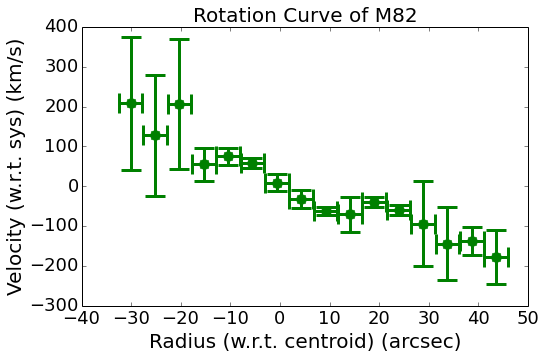

In [35]:
plt.figure(figsize=(8,5))
plt.errorbar(M82_spa_binned, M82_vel_binned, 
             xerr = M82_spa_binerr, yerr = M82_vel_binerr, 
             fmt='g.',capsize=10,capthick=3,elinewidth=3,markersize=20)
plt.title('Rotation Curve of M82')
plt.ylabel('Velocity (w.r.t. sys) (km/s)'); plt.xlabel('Radius (w.r.t. centroid) (arcsec)')

In [36]:
def rotation_curve_exp(r,bulge):
    p2arsec = 12*60/512.
    rp = r/p2arsec
    derivative=spl.derivative()(rp)
    velocity=np.sqrt(rp*derivative)
    #velocity[np.where(r<bulge)]=0
    return velocity

In [37]:
def rc_comb(rarray,a,b, bulge):
    return np.sqrt(a*rotation_curve_exp(rarray,bulge)**2. + b*rotation_curve_kep(rarray,bulge)**2.)
    

In [125]:
#plt.plot(rc_comb(np.arange(1,50),1,350,10))

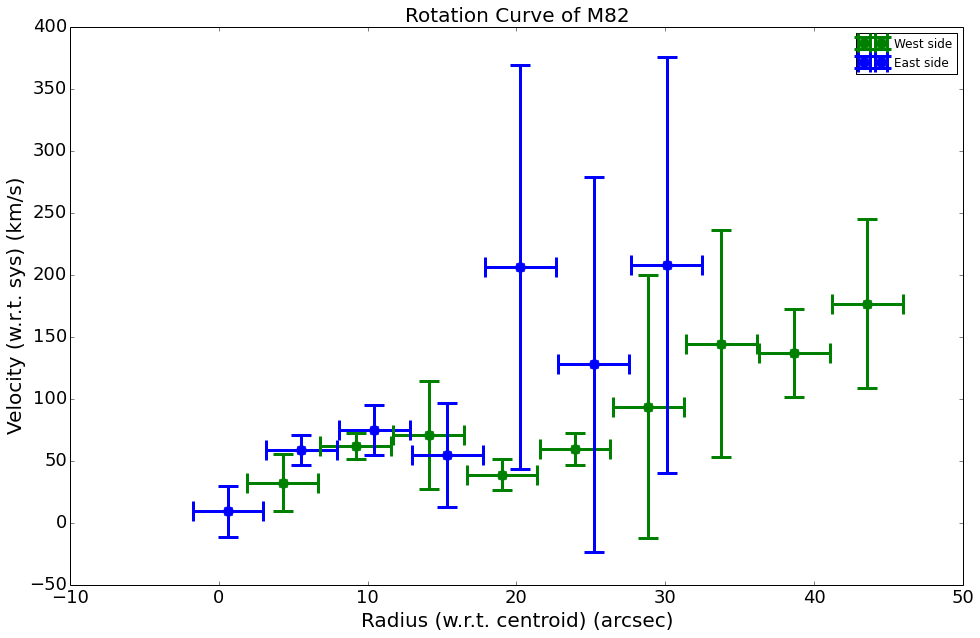

In [38]:
mask = np.where(M82_spa_binned>0)
M82_r = M82_spa_binned[mask]
M82_v = -M82_vel_binned[mask]
M82_v_err = M82_vel_binerr[mask]

mask2 = np.where((M82_spa_binned<0)&(M82_spa_binned>-1000))
M82_r = M82_r
M82_vel_binned[mask2]
M82_vel_binerr[mask2]
plt.figure(figsize=(16,10))
plt.errorbar(M82_r, M82_v, 
             xerr = M82_spa_binerr, yerr = M82_v_err, 
             fmt='g.',capsize=10,capthick=3,elinewidth=3,markersize=20,label='West side')
plt.errorbar(-M82_spa_binned[mask2], M82_vel_binned[mask2], 
             xerr = M82_spa_binerr, yerr = M82_vel_binerr[mask2], 
             fmt='b.',capsize=10,capthick=3,elinewidth=3,markersize=20,label='East side')
plt.title('Rotation Curve of M82'); plt.legend()
plt.ylabel('Velocity (w.r.t. sys) (km/s)'); plt.xlabel('Radius (w.r.t. centroid) (arcsec)')

In [138]:
param_bounds=([0,0,0], [np.inf,np.inf,np.inf])
mask = np.where(M82_r<500)
popt, pcov=op.curve_fit(rc_comb, M82_r[mask], M82_v[mask], p0=[10,10,100],bounds=param_bounds)
print popt

[   44.96554298  1619.22243296     2.83888965]


a: 44.9655429762, b: 1619.22243296


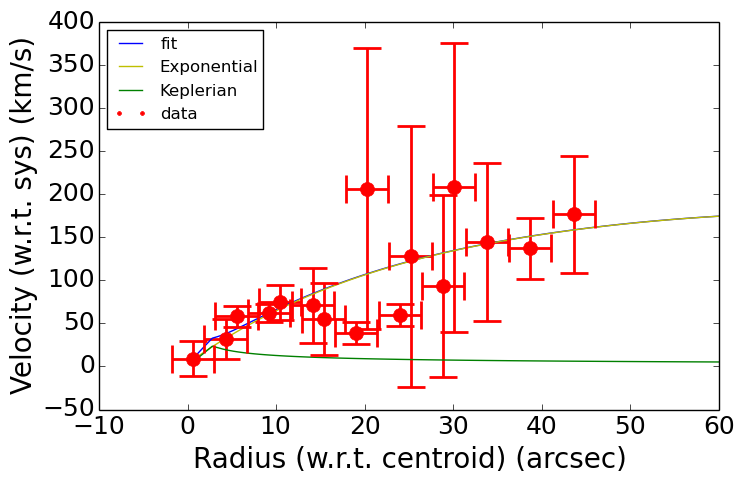

In [139]:
plt.figure(figsize=(8,5))
rfit = np.linspace(1,60,100)
plt.plot(rfit, rc_comb(rfit, *popt), label="fit")
plt.plot(rfit, rotation_curve_exp(rfit,popt[2])*np.sqrt(popt[0]),'y' , label='Exponential')
plt.plot(rfit, rotation_curve_kep(rfit,popt[2])*np.sqrt(popt[1]),'g' , label='Keplerian')
#plt.plot(M82_r,M82_v,marker='.',c="r",label='right side data')
plt.plot(M82_r, M82_v, 'r.', label='data')
plt.errorbar(M82_r[mask], M82_v[mask], 
             xerr = M82_spa_binerr, yerr = M82_v_err[mask], 
             fmt='r.',capsize=10,capthick=2,elinewidth=2,markersize=20)
plt.legend(loc='upper left')
print "a: {0}, b: {1}".format(popt[0], popt[1])
plt.ylabel('Velocity (w.r.t. sys) (km/s)'); plt.xlabel('Radius (w.r.t. centroid) (arcsec)')

In [323]:
chi2 = np.sum(((M82_v - rc_comb(M82_r,*popt))/M82_v_err)**2)
dof = len(M82_v)-1-2
chi2/dof

4.1051024373928007

The probability of a chi2 larger than this is 0.0988

## Investigate exponential rotation curve to larger radius

In [324]:
 popt, pcov = op.curve_fit(fitFunction, rightRadius,rightNorm, p0=(30,1500,50))

In [285]:
x = np.arange(-360, 360.3, 0.3)
y = np.arange(-360, 360.3, 0.3)
xv, yv = np.meshgrid(x, y)
M=np.exp(-np.sqrt((xv**2+yv**2))/popt[0])

In [147]:
def U(x):
    cent=np.array([x,0])
    distArray=np.sqrt(((xv-x)**2+yv**2))
    mask=np.where(distArray>1.)
    Utotal=-np.nansum(M[mask]/distArray[mask])
    return Utotal

In [148]:
x=np.arange(1,300,3)
Utotal=[]
for item in x:
    Utotal.append(U(item))

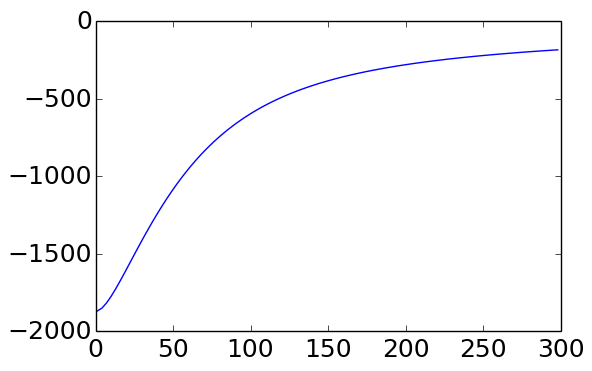

In [149]:
plt.plot(x,Utotal)

In [145]:
spl = UnivariateSpline(x, Utotal, k=4, s=10)

invalid value encountered in sqrt


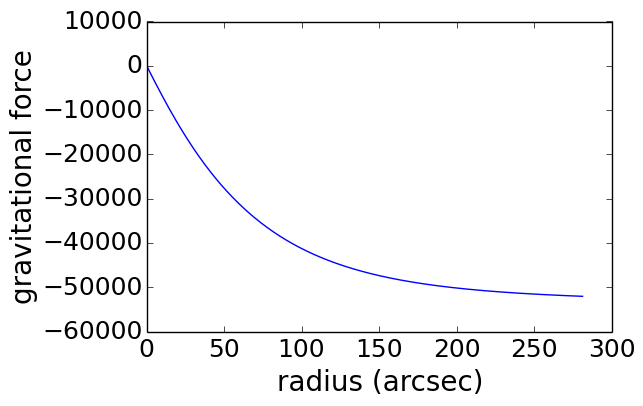

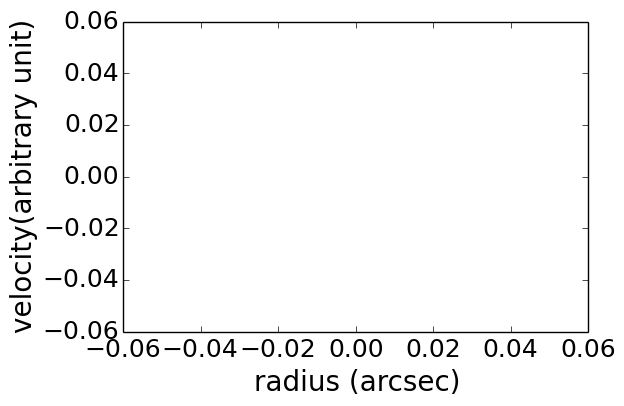

In [146]:
p2arsec = 12*60/512.
radius = np.linspace(0,200,1000)
derivative =spl.derivative()(radius)
velocity=np.sqrt(radius*derivative)
fig=plt.figure()
plt.plot(radius*p2arsec, derivative)
plt.xlabel("radius (arcsec)")
plt.ylabel("gravitational force")

fig=plt.figure()
plt.plot(radius*p2arsec, velocity)
plt.xlabel("radius (arcsec)")
plt.ylabel("velocity(arbitrary unit)")


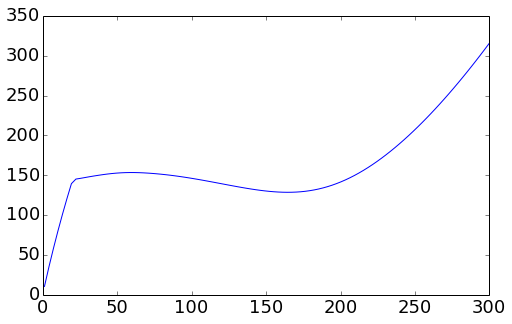

In [251]:
plt.figure(figsize=(8,5))
rfit = np.linspace(1,300,100)
plt.plot(rfit, rc_comb(rfit, *popt), label="fit")

In [210]:
dof

8

In [326]:
def pc(arcsec):
    return 3437746.77*arcsec/3600/180*np.pi

In [329]:
pc(4.8)

79.99999998173364